In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from OptWind import windOpt_linear
from OptJoint import jointOpt_linear
from OptStorage import storageOpt_linear
from OptJoint import jointOpt_linear_noArb
from OptDisjoint import disjointOpt_linear
import matplotlib.pyplot as plt

In [2]:
res_profile = np.load('./Interresult/solar_summer.npz')['data']
netload_profile = np.load('./Interresult/loadnet_summer.npz')['data']
T = len(netload_profile)
alpha = np.zeros(T)
beta_base = np.zeros(T)
for i, d in enumerate(netload_profile):
    if d>=10.9 and d<=51.0:
        alpha[i] = 25.94 + 0.12 *d
        beta_base[i] = 0.12 
    elif d> 51.0 and d<= 58.0:
        alpha[i] = -82.25 + 2.28 *d
        beta_base[i] = 2.28
    elif d>=58.0 and d<= 67.8:
        alpha[i] =  -0.47 + 0.8 *d
        beta_base[i] = 0.8
    else:
        print('ERROR!')
beta= np.diag(beta_base)

In [3]:
s_cap = 2
w_cap = 2
s_ub = s_cap* np.ones(T)
s_ub[-1] = s_ub[-1] - 0.5*s_cap
s_lb = 0* np.ones(T)
s_lb[-1] = s_lb[-1] + 0.5*s_cap
s_init = np.zeros(T)
s_init[0] = 0.5 * s_cap
eta_c = 1
eta_d = 1

# w_cap = 1
w_true = res_profile * w_cap /100

w_j, x_j, s, m = jointOpt_linear(T, alpha, beta, w_true, s_ub, s_lb, s_init, eta_c, eta_d)
price_j = alpha-(w_j+x_j)@beta
w_n, x_n, s_n, m_n = jointOpt_linear_noArb(T, alpha, beta, w_true, s_ub, s_lb, s_init, eta_c, eta_d)
price_n = alpha-(w_n+x_n)@beta
w2_linear, m2_linear = windOpt_linear(T, alpha, beta, w_true)
price_ori = alpha-(w2_linear)@beta
eps = 1e-3
kUb = 10
w_sol_try, x_sol_try, m_disjoint_wind_try, m_disjoint_storage_try=disjointOpt_linear(T, alpha, beta, w_true, s_ub, s_lb, s_init, eta_c, eta_d, eps, kUb)
price_d = alpha-(w_sol_try+ x_sol_try)@beta

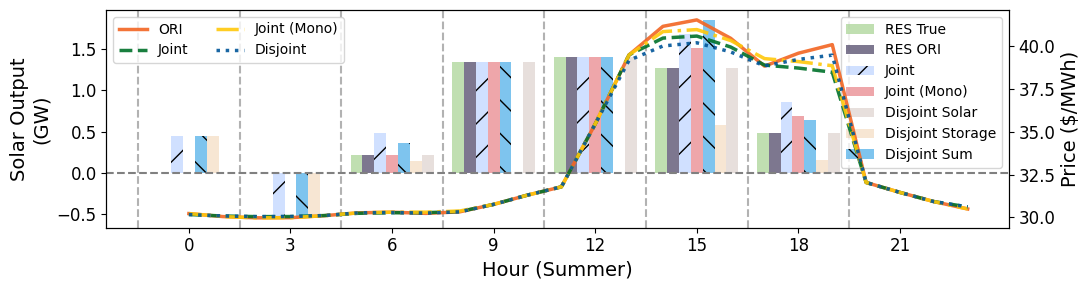

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 3)
ax2 = plt.twinx()
width = 0.7
bar_alpha = 0.7
labels = np.arange(0,T,3)
x = labels  # the label locations
xx = range(T)
ax2.plot(xx, price_ori,label='ORI',color='#f26522',linestyle='-',linewidth = 2.5, alpha=0.9)
ax2.plot(xx, price_j,label='Joint',color='#00712a',linestyle='--',linewidth = 2.5, alpha=0.9)
ax2.plot(xx, price_n,label='Joint (Mono)',color='#ffc80b',linestyle='-.',linewidth = 2.5, alpha=0.9)
ax2.plot(xx, price_d,label='Disjoint',color='#005599',linestyle=':',linewidth = 2.5, alpha=0.9)

rects1 = ax.bar(x - width/2*3, w_true[labels], width/2, label='RES True', alpha=bar_alpha, color="#a6d291")
rects2 = ax.bar(x - width, w2_linear[labels], width/2, label='RES ORI', alpha=bar_alpha, color="#463d60")
rects3 = ax.bar(x - width/2, w_j[labels]+x_j[labels], width/2, label='Joint', alpha=0.3, color="#6699ff", hatch='/')
rects4 = ax.bar(x , w_n[labels]+x_n[labels], width/2, label='Joint (Mono)', alpha=bar_alpha, color="#e88187") 
rects5 = ax.bar(x + width/2*3, w_sol_try[labels], width/2, label='Disjoint Solar', alpha=bar_alpha, color="#ddd2ce")
rects6 = ax.bar(x + width, x_sol_try[labels], width/2, label='Disjoint Storage', alpha=0.3, color="#e7ae70")
rects7 = ax.bar(x + width/2, x_sol_try[labels]+w_sol_try[labels], width/2,  label='Disjoint Sum', alpha=bar_alpha, color="#48ACE8", hatch='\\')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Solar Output\n(GW)',fontsize=14)
ax2.set_ylabel('Price ($/MWh)',fontsize=14)
ax.set_xticks(x)
ax.set_xlabel('Hour (Summer)',fontsize=14)
ax.set_xticklabels(labels,fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=10,loc="upper right")

ax2.legend(fontsize=10,loc="upper left", ncol=2)
# Add vertical grid lines (remove horizontal grid lines)
line_loc = labels - 1.5
for loc in line_loc:
    ax.axvline(x=loc, color='gray', linestyle='--',alpha = 0.6)
# ax.xaxis.grid(True, which='major')
# Add a vertical grid line at y=0
ax.axhline(y=0, color='gray', linestyle='--')
# ax2.legend(loc="lower right")
fig.tight_layout()
plt.savefig("./pics/R1/Action_solar_summer.pdf")